In [1]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import random
import numpy as np
from random import randrange
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

In [0]:
CROP_SIZE = 43

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2, stride=2, padding=0)
    
    def forward(self, x):
        x = self.relu(self.conv2d(x))
        return self.maxpool2d(x)


class CNNModel(nn.Module):
    def __init__(self, im_size, num_classes=10, num_conv_layers=2, dropout=0.5):
        super(CNNModel, self).__init__()

        self.im_size = im_size
        self.num_conv_layers = num_conv_layers
        self.size_after_convs = int(im_size / 2**num_conv_layers)
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(*[
            ConvBlock(max(1, s), s+32) for s in range(0, 32*self.num_conv_layers, 32)
        ])

        self.ft = nn.Sequential(
            nn.Linear(32*self.num_conv_layers * self.size_after_convs * self.size_after_convs, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.ft2 = nn.Sequential(
            nn.Linear(1024, self.num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 32*self.num_conv_layers * self.size_after_convs * self.size_after_convs)
        x = self.ft(x)
        x = self.ft2(x)
        return x

In [0]:
![ ! -d "Data" ] && unzip -q "{AUX_DATA_ROOT / 'Multi-focus image fusion CNN results/cropped_data_720x720.zip'}"
![ ! -d "Ground_truth" ] && unzip -q "{AUX_DATA_ROOT / 'Multi-focus image fusion CNN results/cropped_gt_720x720.zip'}"
![ ! -d "Data" ] && unzip -q "{AUX_DATA_ROOT / 'BlurDatasetImage.zip'}"
![ ! -d "Ground_truth" ] && unzip -q "{AUX_DATA_ROOT / 'BlurDatasetGT.zip'}"

In [0]:
!mkdir cropped_data
!mkdir cropped_gt
!mv /content/content/cropped_data_720x720/*.png /content/cropped_data/
!mv /content/content/cropped_gt_720x720/*.png /content/cropped_gt/

In [0]:
!rm -r ./content/

In [0]:
!unzip -q /content/drive/My\ Drive/cropped_mask.zip
!unzip -q /content/drive/My\ Drive/test_mask.zip

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(CROP_SIZE, num_conv_layers=2).to(device)

In [11]:
model.load_state_dict(torch.load("/content/drive/My Drive/BM_31.05.2020-17:06:24.pth"))

<All keys matched successfully>

In [0]:
def make_parts_from_img(img,ind_h,ind_w):
  padding = CROP_SIZE // 2
  height,width = img.size()
  img = torch.nn.functional.pad(img,(padding,padding,padding,padding))
  return img[ind_h:ind_h+CROP_SIZE,ind_w:ind_w+CROP_SIZE]

In [0]:
def img_to_mask(imgs,stride=8):
  imgs = [torchvision.transforms.ToTensor()(imgs[i]).mean(dim=0) for i in range(len(imgs))]
  h,w = imgs[0].size()
  bs = len(imgs)
  result = torch.zeros((bs,1,h//stride,w//stride),dtype=torch.float32)
  rang = torch.arange(10,device=device)[None]
  i=0
  for ind_h in range(0,h,stride):
    for ind_w in range(0,w,stride):
      parts = torch.cat([make_parts_from_img(imgs[i],ind_h,ind_w)[None] for i in range(len(imgs))],dim=0)
      ind = (model(parts.unsqueeze(1).to(device))*rang).sum(dim=1).argmin()
      result[ind,0,ind_h//stride,ind_w//stride] = 1
      i += 1
  result = nn.UpsamplingBilinear2d(size=[720,720]).to(device)(result)

  return result


In [0]:
real_mask = torchvision.transforms.ToTensor()(Image.open("real_mask.png"))

In [0]:
imgs = [Image.open("/content/cropped_data/75_1.png"),Image.open("/content/cropped_data/75_2.png")]

In [0]:
res = img_to_mask(imgs,stride=1)

[]

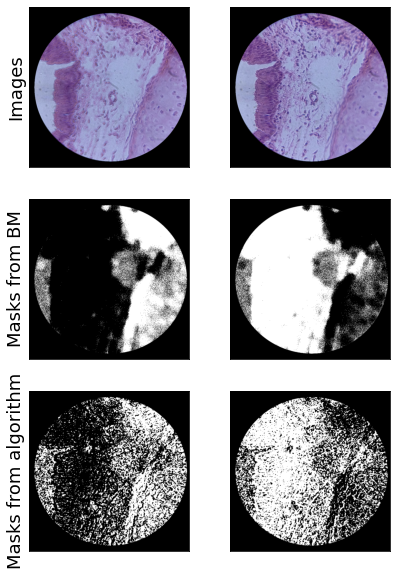

In [42]:
plt.figure(figsize=(6.6,10))
ax = plt.subplot(3,2,1)
ax.imshow(np.array(imgs[0])*(real_mask.numpy()/255).transpose(1,2,0))
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_ylabel("Images",fontsize=18)
ax = plt.subplot(3,2,2)
ax.imshow(np.array(imgs[1])*(real_mask.numpy()/255).transpose(1,2,0))
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax = plt.subplot(3,2,3)
ax.imshow(np.array(torchvision.transforms.ToPILImage()(res[0]*real_mask)),cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_ylabel("Masks from BM",fontsize=18)
ax = plt.subplot(3,2,4)
plt.imshow(np.array(torchvision.transforms.ToPILImage()(res[1]*real_mask)),cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax = plt.subplot(3,2,5)
plt.imshow(np.array(Image.open("/content/test_mask/75_1.png"))*(real_mask.numpy()[0]/255),cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_ylabel("Masks from algorithm",fontsize=18)
ax = plt.subplot(3,2,6)
plt.imshow(np.array(Image.open("/content/test_mask/75_2.png"))*(real_mask.numpy()[0]/255),cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])